クローンとディリクトリの移動

In [ ]:
from torchvision.datasets import Food101

dataset = Food101(root="./data", download=True)

100%|██████████| 5.00G/5.00G [03:43<00:00, 22.4MB/s]


In [ ]:
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader

food_101_classes = [
    "pizza", "bread_pudding", "tiramisu", "tacos", "ice_cream", "takoyaki", "beignets", "nachos",
    "chicken_wings", "clam_chowder", "french_fries", "spring_rolls", "panna_cotta", "miso_soup",
    "ramen", "lasagna", "fried_calamari", "shrimp_and_grits", "gnocchi", "escargots", "gyoza",
    "hot_and_sour_soup", "chocolate_cake", "ceviche", "hamburger", "deviled_eggs", "fish_and_chips",
    "macarons", "apple_pie", "cheese_plate", "bruschetta", "mussels", "paella", "chocolate_mousse",
    "hummus", "spaghetti_bolognese", "creme_brulee", "risotto", "ravioli", "strawberry_shortcake",
    "oysters", "baby_back_ribs", "seaweed_salad", "french_toast", "churros", "donuts",
    "grilled_cheese_sandwich", "poutine", "cheesecake", "chicken_curry", "greek_salad", "falafel",
    "hot_dog", "onion_rings", "pho", "dumplings", "sashimi", "macaroni_and_cheese",
    "pulled_pork_sandwich", "frozen_yogurt", "baklava", "waffles", "pancakes", "peking_duck",
    "croque_madame", "foie_gras", "beet_salad", "beef_carpaccio", "pad_thai", "spaghetti_carbonara",
    "cannoli", "french_onion_soup", "scallops", "bibimbap", "lobster_roll_sandwich", "steak",
    "samosa", "filet_mignon", "huevos_rancheros", "crab_cakes", "grilled_salmon", "edamame",
    "chicken_quesadilla", "fried_rice", "red_velvet_cake", "sushi", "garlic_bread",
    "lobster_bisque", "prime_rib", "caprese_salad", "eggs_benedict", "tuna_tartare",
    "caesar_salad", "guacamole", "breakfast_burrito", "carrot_cake", "club_sandwich", "omelette",
    "pork_chop", "cup_cakes", "beef_tartare"
]

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine((-15, 15), scale=(0.5, 1.5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Food101_train = Food101(root="./data", split="train", download=True, transform=transform_train)
Food101_test = Food101(root="./data", split="test", download=True, transform=transform_test)

train_size = int(0.8 * len(Food101_train))
val_size = len(Food101_train) - train_size

Food101_train, Food101_val = torch.utils.data.random_split(Food101_train, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(Food101_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(Food101_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(Food101_test, batch_size=batch_size, shuffle=False)

In [ ]:
from torchvision.models import resnet18

net = resnet18(pretrained=True)

import torch.nn as nn
net.fc = nn.Linear(net.fc.in_features, 101)

net = net.cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


In [ ]:
from torch import optim


loss_fnc = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

record_loss_train = []
record_loss_test = []

early_stop_patience = 3
best_loss = float('inf')
epoch_no_improve = 0
max_epoch = 50


for i in range(max_epoch):
  net.train()
  loss_train = 0
  for j, (x, t) in enumerate(train_loader):
    x, t = x.cuda(), t.cuda()
    y = net(x)
    loss = loss_fnc(y, t)
    loss_train += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_train /= j+1
  record_loss_train.append(loss_train)


  net.eval()
  loss_test = 0
  with torch.no_grad():
    for j, (x, t) in enumerate(val_loader):
      x, t = x.cuda(), t.cuda()
      y = net(x)
      loss = loss_fnc(y, t)
      loss_test += loss.item()
  loss_test /= j+1
  record_loss_test.append(loss_test)

  print(f"Epoch: {i}, Loss_Train: {loss_train:.4f}, Loss_Test: {loss_test:.4f}")

  if loss_test < best_loss:
    best_loss = loss_test
    epoch_no_improve = 0
    best_model_wts = net.state_dict()
  else:
    epoch_no_improve += 1
    if epoch_no_improve >= early_stop_patience:
      print(f"\nEarly stopping at epoch {i} (no improvement for {early_stop_patience} epoch)")
      break

Epoch: 0, Loss_Train: 2.5627, Loss_Test: 1.8527
Epoch: 1, Loss_Train: 1.5434, Loss_Test: 1.5406
Epoch: 2, Loss_Train: 1.2767, Loss_Test: 1.4449
Epoch: 3, Loss_Train: 1.1212, Loss_Test: 1.3931
Epoch: 4, Loss_Train: 1.0019, Loss_Test: 1.2963
Epoch: 5, Loss_Train: 0.9038, Loss_Test: 1.2438
Epoch: 6, Loss_Train: 0.8195, Loss_Test: 1.2568
Epoch: 7, Loss_Train: 0.7497, Loss_Test: 1.2515
Epoch: 8, Loss_Train: 0.6889, Loss_Test: 1.2787

Early stopping at epoch 8 (no improvement for 3 epoch)


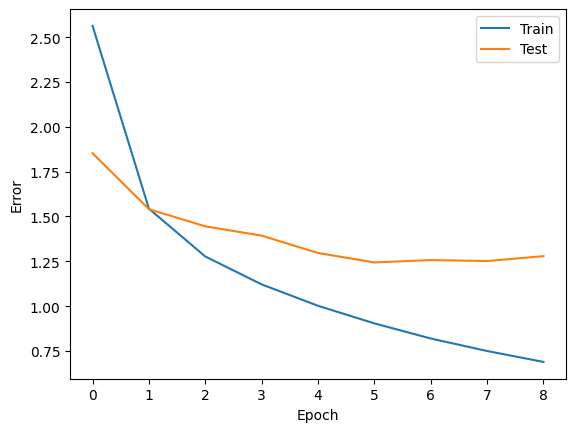

In [ ]:

import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

In [ ]:
correct = 0
total = 0
net.eval()
for i, (x, t) in enumerate(test_loader):
  x, t = x.cuda(), t.cuda()
  y = net(x)
  correct += (y.argmax(1) == t).sum().item()
  total += len(x)
print("正解率：", str(correct/total*100) + "%")

正解率： 76.97425742574258%


In [ ]:
import torch
for key in net.state_dict():
  print(key, net.state_dict()[key].size())

torch.save(net.state_dict(), "model_food101.pth")